In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
 ## imports 
import pandas as pd
import numpy as np
from itertools import product
from sklearn.utils import shuffle
np.random.seed(20)

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [28]:
all_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FinalProject/all_data.csv')
all_data = downcast_dtypes(all_data)
all_data.index = all_data.ID
all_data.head()

,shop_id,item_id,date_block_num,target,monthly_price_avg,returned_cnt_sum,ID,shop_item_id,Q1,Q3,IQR,boxplot_max,boxplot_min,shop_name,shop_name_len,shop_name_word_0,shop_name_word_1,shop_name_word_2,shop_name_word_3,shop_name_word_4,shop_name_word_5,item_name,item_category_id,item_name_len,item_name_word_0,item_name_word_1,item_name_word_2,item_name_word_3,item_name_word_4,item_name_word_5,item_name_word_6,item_name_word_7,item_name_word_8,item_category_name,item_category_name_len,item_category_name_word_0,item_category_name_word_1,item_category_name_word_2,item_category_name_word_3,item_category_name_word_4,item_category_name_word_5,item_category_name_word_6,levenshtein_dist,levenshtein_dist_ratio,item_target_enc,item_Q2,kfold_encoding,loo_encoding,cnt_per_itemid,smoothing_enc,exp_mean_enc,exp_mean_enc2
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12300,1,230,0,0.0,0.0,2.38532,12300,1230,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Дефо Д. Робинзон Крузо,45,5,50,2545,2577,4163,2795,1,1,1,1,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,28,0.379310,0.011905,0.0,0.032258,0.011905,168,0.132201,0.686244,0.013072
12570,1,257,0,0.0,0.0,2.00000,12570,1257,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Карамзин Н.М. История государст...,45,11,50,3007,3479,3211,3791,2506,1843,1285,904,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,87,0.214876,0.058442,0.0,0.076923,0.058442,154,0.167047,0.686244,0.054945
12590,1,259,0,0.0,0.0,2.38532,12590,1259,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Киплинг Р. Сказки и легенды (Di...,45,7,50,3021,3945,4330,3906,3079,116,1,1,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,43,0.324324,0.087901,0.0,0.065476,0.087901,967,0.110993,0.686244,0.092643
12670,1,267,0,0.0,0.0,2.38532,12670,1267,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Коллекция русских народных сказ...,45,6,50,3039,5318,5227,4465,166,1,1,1,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,48,0.275000,0.011628,0.0,0.334300,0.011628,86,0.185108,0.686244,0.000000
12760,1,276,0,0.0,0.0,2.38532,12760,1276,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Кун Н.А. Легенды и мифы древней...,45,9,50,3085,3477,3455,3906,3147,2258,1229,53,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,49,0.317073,0.097087,0.0,0.000000,0.097087,103,0.213941,0.686244,0.000000


In [29]:
## concatenate test set, which in turn is merged by shop_item_id
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FinalProject/test.csv.gz', index_col='ID')
test = downcast_dtypes(test)
test['shop_item_id'] = (test['shop_id'].astype(str) + test['item_id'].astype(str)).astype(int)
test['date_block_num'] = all_data['date_block_num'].max() + 1
test['ID'] = test['shop_id'].astype(str) + test['item_id'].astype(str) + test['date_block_num'].astype(str)
test = pd.merge(test, all_data.drop(columns=['date_block_num', 'target', 
                                             'monthly_price_avg', 'returned_cnt_sum', 'ID', 'shop_id', 'item_id']).groupby('shop_item_id').mean(),
                left_on='shop_item_id', right_index=True, how='left')
test.head()

,shop_id,item_id,shop_item_id,date_block_num,ID,Q1,Q3,IQR,boxplot_max,boxplot_min,shop_name_len,shop_name_word_0,shop_name_word_1,shop_name_word_2,shop_name_word_3,shop_name_word_4,shop_name_word_5,item_category_id,item_name_len,item_name_word_0,item_name_word_1,item_name_word_2,item_name_word_3,item_name_word_4,item_name_word_5,item_name_word_6,item_name_word_7,item_name_word_8,item_category_name_len,item_category_name_word_0,item_category_name_word_1,item_category_name_word_2,item_category_name_word_3,item_category_name_word_4,item_category_name_word_5,item_category_name_word_6,levenshtein_dist,levenshtein_dist_ratio,item_target_enc,item_Q2,kfold_encoding,loo_encoding,cnt_per_itemid,smoothing_enc,exp_mean_enc,exp_mean_enc2
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5,5037,55037,34,5503734,0.0,3.000,3.000,7.5000,-4.5000,3.0,4.0,8.0,20.0,0.0,0.0,0.0,19.00,5.000,921.00,225.000,2027.000,5425.00,4522.00,1.00,1.00,1.000,1.000,3.000,5.000,2.0,12.0,0.000,0.0,0.0,0.0,26.00,0.250000,1.931034,1.000,1.880100,1.929433,580.000,1.696221,2.401484,2.217267
1,5,5320,55320,34,5532034,0.0,0.000,0.000,0.0000,0.0000,3.0,28.0,12.0,40.0,0.0,0.0,0.0,45.00,13.000,50.00,3422.000,2330.000,3616.00,4177.00,2505.00,1830.00,1887.000,1348.000,4.000,8.000,2.0,20.0,3.000,0.0,0.0,0.0,82.00,0.224138,0.142857,0.000,0.128810,0.142857,105.000,0.236244,0.193419,0.103755
2,5,5233,55233,34,5523334,0.0,2.625,2.625,6.5625,-3.9375,3.0,7.0,8.5,22.5,0.0,0.0,0.0,22.25,8.375,825.25,1810.375,1884.625,2201.50,589.75,2022.50,2591.75,1581.125,177.125,3.125,5.375,2.0,13.0,0.375,0.0,0.0,0.0,52.50,0.166081,1.448390,0.875,1.492203,1.443655,231.875,1.169895,0.936113,1.538261
3,5,5232,55232,34,5523234,0.0,1.500,1.500,3.7500,-2.2500,3.0,10.0,9.0,25.0,0.0,0.0,0.0,28.50,8.250,714.50,1915.500,2111.250,2484.75,1242.75,1438.25,316.75,1411.750,850.750,4.000,5.750,2.0,17.0,3.750,0.0,0.0,0.0,48.75,0.230127,0.834783,0.750,0.334300,0.832609,89.250,0.637748,1.040728,0.862323
4,5,5268,55268,34,5526834,0.0,0.250,0.250,0.6250,-0.3750,3.0,28.0,12.0,40.0,0.0,0.0,0.0,44.00,8.000,50.00,3039.000,5318.000,5227.00,4465.00,1846.00,2051.00,1554.000,1.000,4.000,8.000,2.0,20.0,1.000,0.0,0.0,0.0,54.00,0.333333,0.250000,0.000,0.334300,0.000000,4.000,0.331058,0.000000,0.000000


In [30]:
# now concatenate dataframe
print('Test shape', test.shape)
print('all_data shape', all_data.shape)
print('max date block num before concatenation', all_data['date_block_num'].max())
df_full = pd.concat([all_data, test], ignore_index=True)
print('df_full shape', df_full.shape)
print('max date block num after concatenation', df_full['date_block_num'].max())
df_full.tail()

Test shape (214200, 46)
all_data shape (2760686, 52)
max date block num before concatenation 33


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


df_full shape (2974886, 52)
max date block num after concatenation 34


,ID,IQR,Q1,Q3,boxplot_max,boxplot_min,cnt_per_itemid,date_block_num,exp_mean_enc,exp_mean_enc2,item_Q2,item_category_id,item_category_name,item_category_name_len,item_category_name_word_0,item_category_name_word_1,item_category_name_word_2,item_category_name_word_3,item_category_name_word_4,item_category_name_word_5,item_category_name_word_6,item_id,item_name,item_name_len,item_name_word_0,item_name_word_1,item_name_word_2,item_name_word_3,item_name_word_4,item_name_word_5,item_name_word_6,item_name_word_7,item_name_word_8,item_target_enc,kfold_encoding,levenshtein_dist,levenshtein_dist_ratio,loo_encoding,monthly_price_avg,returned_cnt_sum,shop_id,shop_item_id,shop_name,shop_name_len,shop_name_word_0,shop_name_word_1,shop_name_word_2,shop_name_word_3,shop_name_word_4,shop_name_word_5,smoothing_enc,target
2974881,451845434,1.0,0.0,1.0,2.5,-1.5,451.000,34,1.754465,1.142163,0.0,55.000,NaN,5.00,9.00,2.0,7.000,32.00,12.0,0.0,0.0,18454,NaN,3.000,4318.000,4427.00,449.000,1.000,1.00,1.0,1.0,1.0,1.0,1.017738,1.084858,32.000,0.130435,1.015924,NaN,NaN,45,4518454,NaN,3.000,21.00,9.0,27.000,0.000,0.0,0.0,0.893702,NaN
2974882,451618834,0.0,0.0,0.0,0.0,0.0,83.000,34,0.057143,0.269819,0.0,64.000,NaN,4.00,10.00,2.0,33.000,29.00,0.0,0.0,0.0,16188,NaN,4.000,3621.000,5047.00,3546.000,3406.000,1.00,1.0,1.0,1.0,1.0,0.048193,0.334300,23.000,0.452830,0.048193,NaN,NaN,45,4516188,NaN,3.000,21.00,9.0,27.000,0.000,0.0,0.0,0.204536,NaN
2974883,451575734,0.0,0.0,0.0,0.0,0.0,1327.000,34,0.254440,0.223683,0.0,55.000,NaN,5.00,9.00,2.0,7.000,32.00,12.0,0.0,0.0,15757,NaN,5.000,3576.000,1780.00,0.000,3770.000,3978.00,1.0,1.0,1.0,1.0,0.225320,0.220173,33.000,0.231884,0.225165,NaN,NaN,45,4515757,NaN,3.000,21.00,9.0,27.000,0.000,0.0,0.0,0.232957,NaN
2974884,451964834,0.0,0.0,0.0,0.0,0.0,451.000,34,0.148915,0.116819,0.0,40.000,NaN,3.00,7.00,2.0,8.000,0.00,0.0,0.0,0.0,19648,NaN,5.000,4695.000,178.00,4374.000,5440.000,226.00,1.0,1.0,1.0,1.0,0.108647,0.113291,28.000,0.146341,0.108647,NaN,NaN,45,4519648,NaN,3.000,21.00,9.0,27.000,0.000,0.0,0.0,0.149601,NaN
2974885,4596934,0.0,0.0,0.0,0.0,0.0,227.125,34,0.356584,0.130322,0.0,39.375,NaN,3.25,7.25,2.0,6.125,4.75,1.5,0.0,0.0,969,NaN,4.875,227.375,2280.25,3262.625,3968.625,111.25,1.0,1.0,1.0,1.0,0.172297,0.237165,21.375,0.176535,0.171815,NaN,NaN,45,45969,NaN,3.125,18.75,9.0,24.875,1.875,0.0,0.0,0.245964,NaN


In [31]:
#create further encodings (revenue, per date_block)

# revenue
df_full['monthly_revenue'] = df_full['target'] * df_full['monthly_price_avg']
df_full['shop_avg_revenue'] = df_full.groupby('shop_id')['monthly_revenue'].transform('mean')
df_full['shop_Q2_revenue'] = df_full.groupby('shop_id')['monthly_revenue'].transform('median')
df_full['item_Q2_revenue'] = df_full.groupby('shop_id')['monthly_revenue'].transform('median')

# encodings grouping by different ids.
df_full['item_month_avg_target'] = df_full.groupby(['item_id', 'date_block_num'])['target'].transform('mean')
df_full['item_cat_avg_target'] = df_full.groupby(['item_id', 'item_category_id'])['target'].transform('mean')

df_full['item_month_avg_price'] = df_full.groupby(['item_id', 'date_block_num'])['monthly_price_avg'].transform('mean')
df_full['item_cat_avg_price'] = df_full.groupby(['item_id', 'item_category_id'])['monthly_price_avg'].transform('mean')

# month (1 through 12)
df_full['month'] = df_full['date_block_num'] % 12 + 1

#drop name cols as they already are encoded with id
df_full.drop(columns=['item_name', 'shop_name', 'item_category_name'], inplace=True)
df_full.head()

,ID,IQR,Q1,Q3,boxplot_max,boxplot_min,cnt_per_itemid,date_block_num,exp_mean_enc,exp_mean_enc2,item_Q2,item_category_id,item_category_name_len,item_category_name_word_0,item_category_name_word_1,item_category_name_word_2,item_category_name_word_3,item_category_name_word_4,item_category_name_word_5,item_category_name_word_6,item_id,item_name_len,item_name_word_0,item_name_word_1,item_name_word_2,item_name_word_3,item_name_word_4,item_name_word_5,item_name_word_6,item_name_word_7,item_name_word_8,item_target_enc,kfold_encoding,levenshtein_dist,levenshtein_dist_ratio,loo_encoding,monthly_price_avg,returned_cnt_sum,shop_id,shop_item_id,shop_name_len,shop_name_word_0,shop_name_word_1,shop_name_word_2,shop_name_word_3,shop_name_word_4,shop_name_word_5,smoothing_enc,target,monthly_revenue,shop_avg_revenue,shop_Q2_revenue,item_Q2_revenue,item_month_avg_target,item_cat_avg_target,item_month_avg_price,item_cat_avg_price,month
0,12300,0.0,0.0,0.0,0.0,0.0,168.0,0,0.686244,0.013072,0.0,45.0,4.0,8.0,2.0,20.0,3.0,0.0,0.0,0.0,230,5.0,50.0,2545.0,2577.0,4163.0,2795.0,1.0,1.0,1.0,1.0,0.011905,0.032258,28.0,0.379310,0.011905,0.0,2.38532,1,1230,4.0,0.0,9.0,38.0,21.0,0.0,0.0,0.132201,0.0,0.0,194.958832,0.0,0.0,0.000000,0.011905,0.00000,2.976191,1
1,12570,0.0,0.0,0.0,0.0,0.0,154.0,0,0.686244,0.054945,0.0,45.0,4.0,8.0,2.0,20.0,3.0,0.0,0.0,0.0,257,11.0,50.0,3007.0,3479.0,3211.0,3791.0,2506.0,1843.0,1285.0,904.0,0.058442,0.076923,87.0,0.214876,0.058442,0.0,2.00000,1,1257,4.0,0.0,9.0,38.0,21.0,0.0,0.0,0.167047,0.0,0.0,194.958832,0.0,0.0,0.000000,0.058442,0.00000,9.701299,1
2,12590,0.0,0.0,0.0,0.0,0.0,967.0,0,0.686244,0.092643,0.0,45.0,4.0,8.0,2.0,20.0,3.0,0.0,0.0,0.0,259,7.0,50.0,3021.0,3945.0,4330.0,3906.0,3079.0,116.0,1.0,1.0,0.087901,0.065476,43.0,0.324324,0.087901,0.0,2.38532,1,1259,4.0,0.0,9.0,38.0,21.0,0.0,0.0,0.110993,0.0,0.0,194.958832,0.0,0.0,0.120000,0.087901,19.92000,17.797209,1
3,12670,0.0,0.0,0.0,0.0,0.0,86.0,0,0.686244,0.000000,0.0,45.0,4.0,8.0,2.0,20.0,3.0,0.0,0.0,0.0,267,6.0,50.0,3039.0,5318.0,5227.0,4465.0,166.0,1.0,1.0,1.0,0.011628,0.334300,48.0,0.275000,0.011628,0.0,2.38532,1,1267,4.0,0.0,9.0,38.0,21.0,0.0,0.0,0.185108,0.0,0.0,194.958832,0.0,0.0,0.000000,0.011628,0.00000,2.895349,1
4,12760,0.0,0.0,0.0,0.0,0.0,103.0,0,0.686244,0.000000,0.0,45.0,4.0,8.0,2.0,20.0,3.0,0.0,0.0,0.0,276,9.0,50.0,3085.0,3477.0,3455.0,3906.0,3147.0,2258.0,1229.0,53.0,0.097087,0.000000,49.0,0.317073,0.097087,0.0,2.38532,1,1276,4.0,0.0,9.0,38.0,21.0,0.0,0.0,0.213941,0.0,0.0,194.958832,0.0,0.0,0.142857,0.097087,35.57143,19.339806,1


In [32]:
df_full.columns.values

array(['ID', 'IQR', 'Q1', 'Q3', 'boxplot_max', 'boxplot_min',
       'cnt_per_itemid', 'date_block_num', 'exp_mean_enc',
       'exp_mean_enc2', 'item_Q2', 'item_category_id',
       'item_category_name_len', 'item_category_name_word_0',
       'item_category_name_word_1', 'item_category_name_word_2',
       'item_category_name_word_3', 'item_category_name_word_4',
       'item_category_name_word_5', 'item_category_name_word_6',
       'item_id', 'item_name_len', 'item_name_word_0', 'item_name_word_1',
       'item_name_word_2', 'item_name_word_3', 'item_name_word_4',
       'item_name_word_5', 'item_name_word_6', 'item_name_word_7',
       'item_name_word_8', 'item_target_enc', 'kfold_encoding',
       'levenshtein_dist', 'levenshtein_dist_ratio', 'loo_encoding',
       'monthly_price_avg', 'returned_cnt_sum', 'shop_id', 'shop_item_id',
       'shop_name_len', 'shop_name_word_0', 'shop_name_word_1',
       'shop_name_word_2', 'shop_name_word_3', 'shop_name_word_4',
       'shop_name_w

In [0]:
# function for lag feats
def create_lag_feats(df, shift_range, colname):
  """Given a colname and a shift list (how many months), lag features are created.
  """
  
  for i in shift_range:
    df[f'{colname}_lag_{i}'] = np.nan
  
  for i in df[df['date_block_num'] >=13 ]['date_block_num'].unique():
    for j in shift_range:
      #target lag
      target_lag = df[df['date_block_num']== i-j].groupby('shop_item_id')[colname].mean()    
      df.loc[df['date_block_num'] == i, f'{colname}_lag_{j}'] = df[df['date_block_num'] == i]['shop_item_id'].map(target_lag)

  
  
  return df

In [0]:
# before applying function, save df as aux to save memory
df_full[df_full['date_block_num'] >= 13].to_csv('/content/drive/My Drive/Colab Notebooks/FinalProject/aux.csv', index=False)
df_full = df_full[['ID', 'date_block_num','target', 'returned_cnt_sum', 'monthly_revenue', 'item_month_avg_price', 'shop_item_id']]

In [35]:
# apply function
lag_feats_cols = ['target', 'returned_cnt_sum', 'monthly_revenue', 'item_month_avg_price']
for col in lag_feats_cols:
  df_full = create_lag_feats(df_full, [1,2,3,6,12], col)

cols_to_drop = ['returned_cnt_sum', 'monthly_revenue', 'item_month_avg_price']
df_full.drop(columns=cols_to_drop, inplace=True)

aux = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FinalProject/aux.csv')
aux = downcast_dtypes(aux)
# make it since 2013
df_full = df_full[df_full['date_block_num'] >= 13]
# merge aux
df_full = pd.merge(aux, df_full.drop(columns=['date_block_num', 'target', 'shop_item_id']), on='ID', how='left')
del aux # to save memory
# fill na
for i in df_full.columns:
  df_full[i].fillna(df_full[i].median(), inplace=True)

df_full.tail()

,ID,IQR,Q1,Q3,boxplot_max,boxplot_min,cnt_per_itemid,date_block_num,exp_mean_enc,exp_mean_enc2,item_Q2,item_category_id,item_category_name_len,item_category_name_word_0,item_category_name_word_1,item_category_name_word_2,item_category_name_word_3,item_category_name_word_4,item_category_name_word_5,item_category_name_word_6,item_id,item_name_len,item_name_word_0,item_name_word_1,item_name_word_2,item_name_word_3,item_name_word_4,item_name_word_5,item_name_word_6,item_name_word_7,item_name_word_8,item_target_enc,kfold_encoding,levenshtein_dist,levenshtein_dist_ratio,loo_encoding,monthly_price_avg,returned_cnt_sum,shop_id,shop_item_id,shop_name_len,shop_name_word_0,shop_name_word_1,shop_name_word_2,shop_name_word_3,shop_name_word_4,shop_name_word_5,smoothing_enc,target,monthly_revenue,shop_avg_revenue,shop_Q2_revenue,item_Q2_revenue,item_month_avg_target,item_cat_avg_target,item_month_avg_price,item_cat_avg_price,month,target_lag_1,target_lag_2,target_lag_3,target_lag_6,target_lag_12,returned_cnt_sum_lag_1,returned_cnt_sum_lag_2,returned_cnt_sum_lag_3,returned_cnt_sum_lag_6,returned_cnt_sum_lag_12,monthly_revenue_lag_1,monthly_revenue_lag_2,monthly_revenue_lag_3,monthly_revenue_lag_6,monthly_revenue_lag_12,item_month_avg_price_lag_1,item_month_avg_price_lag_2,item_month_avg_price_lag_3,item_month_avg_price_lag_6,item_month_avg_price_lag_12
2336091,451845434,1.0,0.0,1.0,2.5,-1.5,451.000,34,1.754465,1.142163,0.0,55.000,5.00,9.00,2.0,7.000,32.00,12.0,0.0,0.0,18454,3.000,4318.000,4427.00,449.000,1.000,1.00,1.0,1.0,1.0,1.0,1.017738,1.084858,32.000,0.130435,1.015924,0.0,2.38532,45,4518454,3.000,21.00,9.0,27.000,0.000,0.0,0.0,0.893702,0.0,0.0,272.679077,0.0,0.0,0.170732,1.017738,52.150002,81.387321,11,0.0,0.0,0.0,0.0,0.0,2.38532,2.38532,2.38532,2.38532,2.38532,0.0,0.0,0.0,0.0,0.0,58.341465,58.487804,58.439026,58.341465,54.054054
2336092,451618834,0.0,0.0,0.0,0.0,0.0,83.000,34,0.057143,0.269819,0.0,64.000,4.00,10.00,2.0,33.000,29.00,0.0,0.0,0.0,16188,4.000,3621.000,5047.00,3546.000,3406.000,1.00,1.0,1.0,1.0,1.0,0.048193,0.334300,23.000,0.452830,0.048193,0.0,2.38532,45,4516188,3.000,21.00,9.0,27.000,0.000,0.0,0.0,0.204536,0.0,0.0,272.679077,0.0,0.0,0.170732,0.048193,52.150002,60.577110,11,0.0,0.0,0.0,0.0,0.0,2.38532,2.38532,2.38532,2.38532,2.38532,0.0,0.0,0.0,0.0,0.0,58.341465,58.487804,58.439026,58.341465,54.054054
2336093,451575734,0.0,0.0,0.0,0.0,0.0,1327.000,34,0.254440,0.223683,0.0,55.000,5.00,9.00,2.0,7.000,32.00,12.0,0.0,0.0,15757,5.000,3576.000,1780.00,0.000,3770.000,3978.00,1.0,1.0,1.0,1.0,0.225320,0.220173,33.000,0.231884,0.225165,0.0,2.38532,45,4515757,3.000,21.00,9.0,27.000,0.000,0.0,0.0,0.232957,0.0,0.0,272.679077,0.0,0.0,0.170732,0.225320,52.150002,40.076866,11,0.0,0.0,0.0,0.0,0.0,2.38532,2.38532,2.38532,2.38532,2.38532,0.0,0.0,0.0,0.0,0.0,58.341465,58.487804,58.439026,58.341465,54.054054
2336094,451964834,0.0,0.0,0.0,0.0,0.0,451.000,34,0.148915,0.116819,0.0,40.000,3.00,7.00,2.0,8.000,0.00,0.0,0.0,0.0,19648,5.000,4695.000,178.00,4374.000,5440.000,226.00,1.0,1.0,1.0,1.0,0.108647,0.113291,28.000,0.146341,0.108647,0.0,2.38532,45,4519648,3.000,21.00,9.0,27.000,0.000,0.0,0.0,0.149601,0.0,0.0,272.679077,0.0,0.0,0.170732,0.108647,52.150002,8.297561,11,0.0,0.0,0.0,0.0,0.0,2.38532,2.38532,2.38532,2.38532,2.38532,0.0,0.0,0.0,0.0,0.0,58.341465,58.487804,58.439026,58.341465,54.054054
2336095,4596934,0.0,0.0,0.0,0.0,0.0,227.125,34,0.356584,0.130322,0.0,39.375,3.25,7.25,2.0,6.125,4.75,1.5,0.0,0.0,969,4.875,227.375,2280.25,3262.625,3968.625,111.25,1.0,1.0,1.0,1.0,0.172297,0.237165,21.375,0.176535,0.171815,0.0,2.38532,45,45969,3.125,18.75,9.0,24.875,1.875,0.0,0.0,0.245964,0.0,0.0,272.679077,0.0,0.0,0.170732,0.231707,52.150002,67.558540,11,0.0,0.0,0.0,0.0,0.0,2.38532,2.38532,2.38532,2.38532,2.38532,0.0,0.0,0.0,0.0,0.0,58.341465,58.487804,58.439026,58.341465,54.054054


In [36]:
df_full.columns.values

array(['ID', 'IQR', 'Q1', 'Q3', 'boxplot_max', 'boxplot_min',
       'cnt_per_itemid', 'date_block_num', 'exp_mean_enc',
       'exp_mean_enc2', 'item_Q2', 'item_category_id',
       'item_category_name_len', 'item_category_name_word_0',
       'item_category_name_word_1', 'item_category_name_word_2',
       'item_category_name_word_3', 'item_category_name_word_4',
       'item_category_name_word_5', 'item_category_name_word_6',
       'item_id', 'item_name_len', 'item_name_word_0', 'item_name_word_1',
       'item_name_word_2', 'item_name_word_3', 'item_name_word_4',
       'item_name_word_5', 'item_name_word_6', 'item_name_word_7',
       'item_name_word_8', 'item_target_enc', 'kfold_encoding',
       'levenshtein_dist', 'levenshtein_dist_ratio', 'loo_encoding',
       'monthly_price_avg', 'returned_cnt_sum', 'shop_id', 'shop_item_id',
       'shop_name_len', 'shop_name_word_0', 'shop_name_word_1',
       'shop_name_word_2', 'shop_name_word_3', 'shop_name_word_4',
       'shop_name_w

In [0]:
# drop current date block num features
df_full = df_full.drop(['monthly_revenue', 'item_month_avg_target', 'item_month_avg_price'], axis=1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f280f2bbef0>,
      dtype=object)

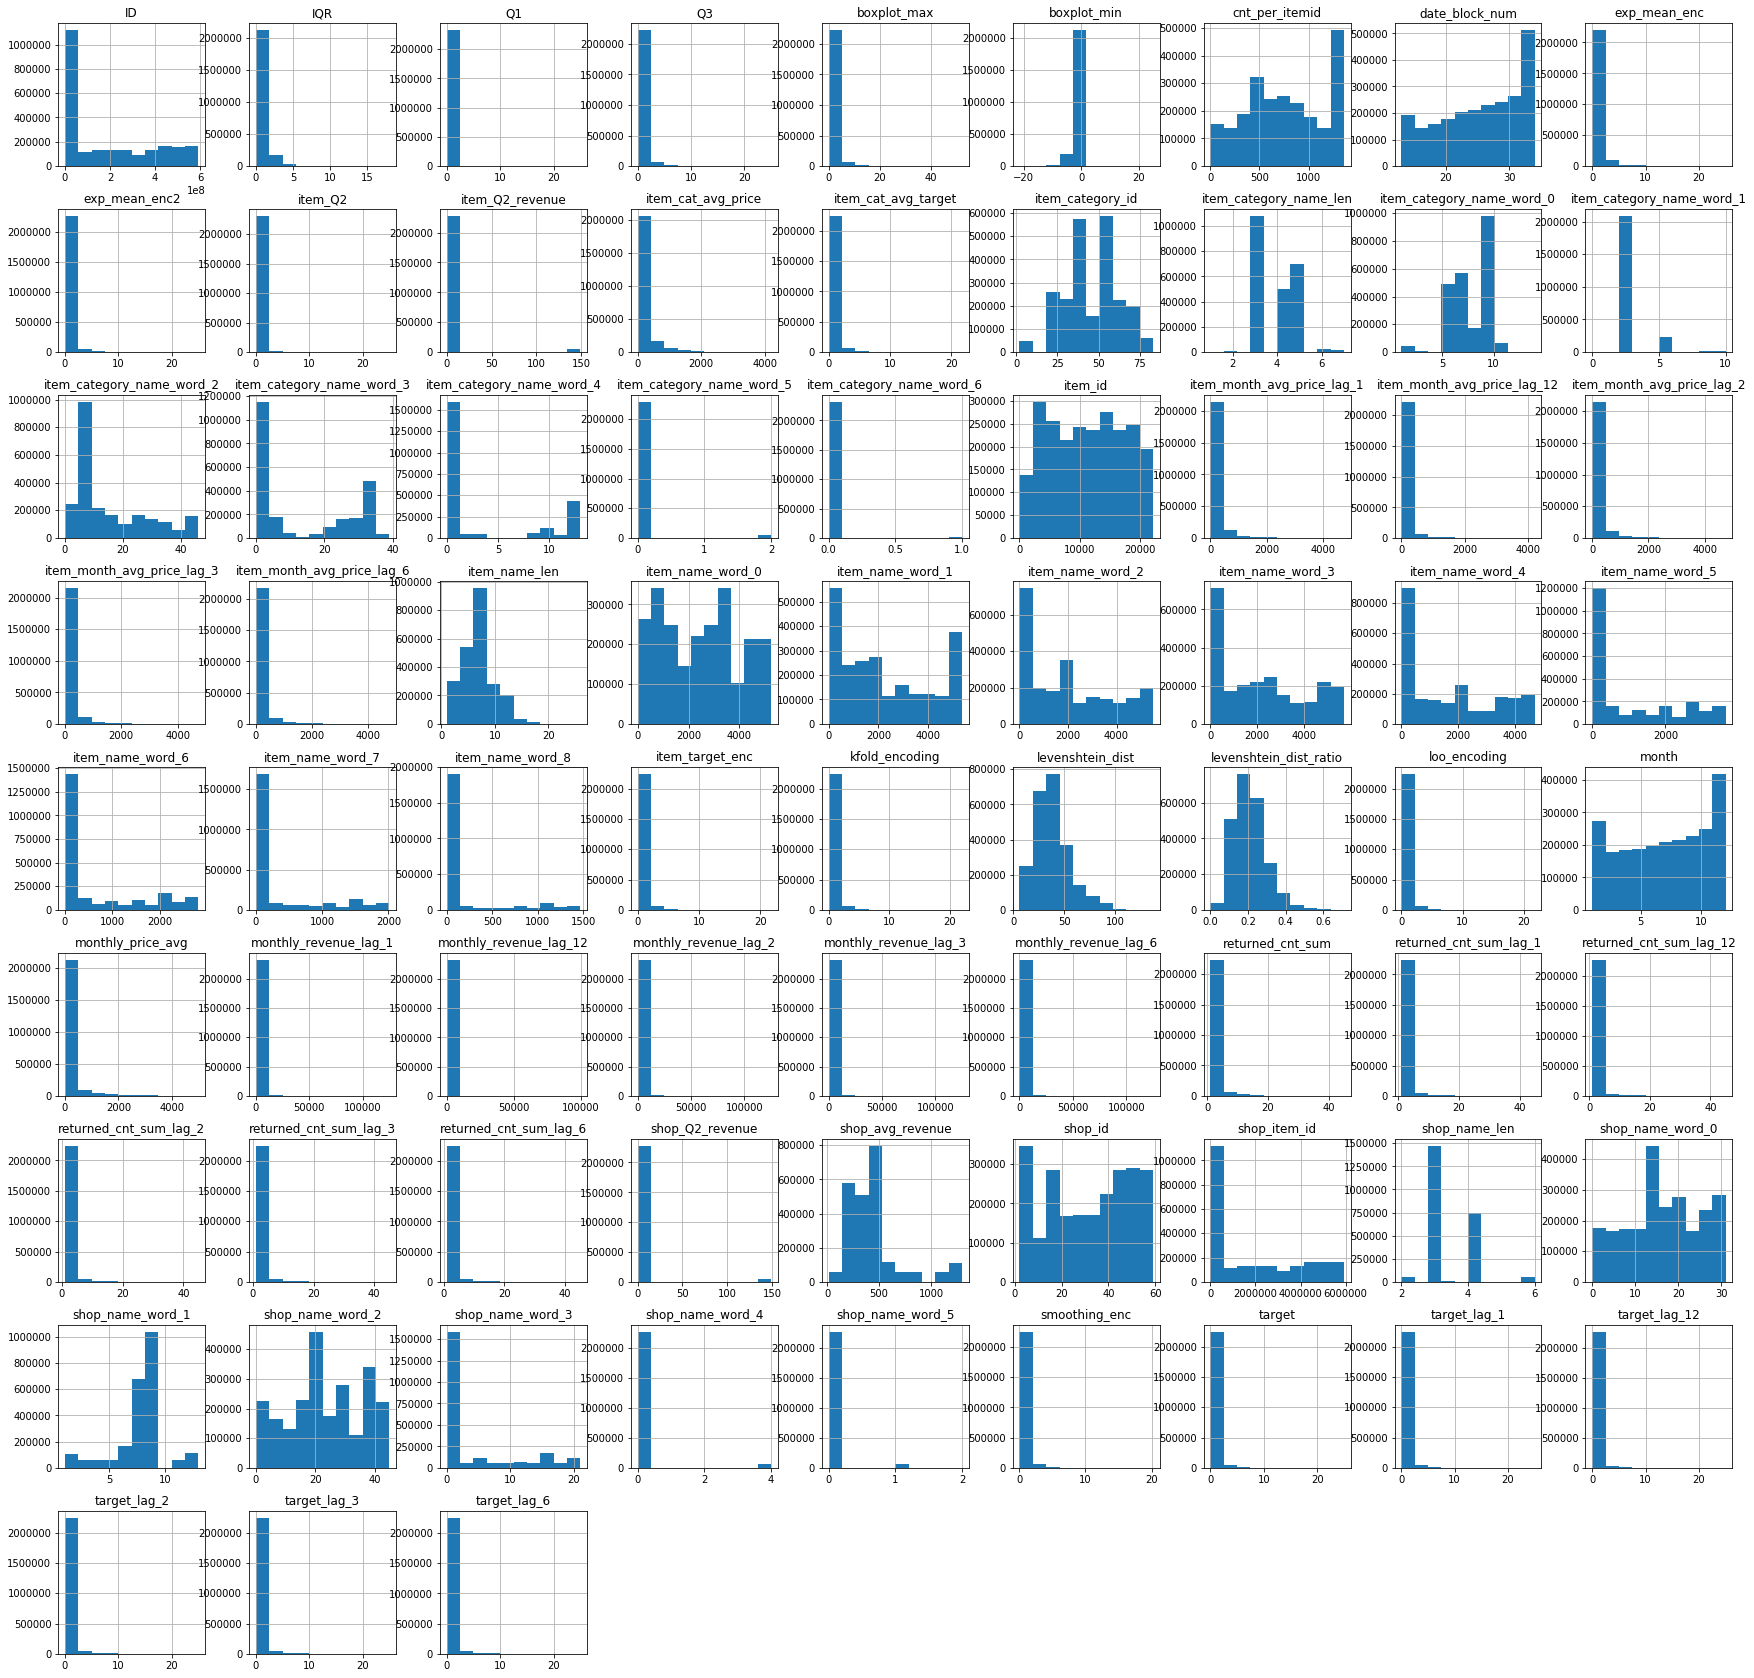

In [38]:
# visualise 
# visualise distribution
df_full.hist(figsize=(30,30))

In [0]:
#save to continue
df_full.to_csv('/content/drive/My Drive/Colab Notebooks/FinalProject/df_full.csv', index=False)